In [ ]:
!pip install torchvision

In [ ]:
!pip install torchinfo

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import copy
import cv2
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

import torchvision
import torchvision.transforms as transforms
import torchvision.utils

from zipfile import ZipFile

from transformers import AutoImageProcessor, Swinv2Model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
use_pre_trained = True # True - load the model already trained and saved, False - train the model
"""
When save_input_classes = True and save_train_test_splitting = True,
the initial splitting of the data into training and test sets is performed.
"""
save_input_classes = False
save_train_test_splitting = False

In [ ]:
DATA_PATH = '/content/gdrive/MyDrive/'
CURR_PATH = '/content/gdrive/MyDrive/Colab Notebooks/'

FILE_NAME = CURR_PATH + 'model_seg_pytorch_medical.cnn'   # to save the model check-points during the training
FILE_NAME_PR = CURR_PATH + 'model_seg_pytorch_medical.cnn_23' # the pre-trained model

r_size = 256
batch_size = 16
ep_num = 23

zip_name = 'ISSBI2015.zip'

In [ ]:
with ZipFile(DATA_PATH + zip_name, 'r') as f:
    names = f.namelist()

len(names), names[10]

(7608, 'ISSBI2015/training1/training01_01_flair_pp_slice_101+mask.tiff')

In [ ]:
names = [n.split('/')[-1] for n in names]
names = list(filter(lambda x: (x != '' and x != 'data.csv' and x != 'README.md'), names))
names[0], len(names)

('training01_01_flair_pp_slice_0+mask.tiff', 7602)

In [ ]:
f_names = [ 'ISSBI2015/' + n[:8]+n[9] + '/' + n for n in names]
f_names[0]

'ISSBI2015/training1/training01_01_flair_pp_slice_0+mask.tiff'

In [ ]:
f_images = list(filter(lambda x: 'mask' not in x, f_names))
f_images[0], len(f_images)

('ISSBI2015/training1/training01_01_flair_pp_slice_0.tiff', 3801)

In [ ]:
f_masks = list(filter(lambda x: 'mask' in x, f_names))
f_masks[0], len(f_masks)

('ISSBI2015/training1/training01_01_flair_pp_slice_0+mask.tiff', 3801)

In [ ]:
del f_names
del f_masks

In [ ]:
def show_input_sample(f_images):
    random.shuffle(f_images)
    with ZipFile(DATA_PATH + zip_name) as archive:
        data = archive.read(f_images[0])
        print(f_images[0][:-5] + '+mask.tiff')
        data1 = archive.read(f_images[0][:-5] + '+mask.tiff')

    img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    print(mask.max(), mask.min(), np.unique(mask))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axes[0].imshow(img)
    axes[1].imshow(mask)
    plt.show()

ISSBI2015/training1/training01_02_flair_pp_slice_59+mask.tiff
255 0 [  0 255]


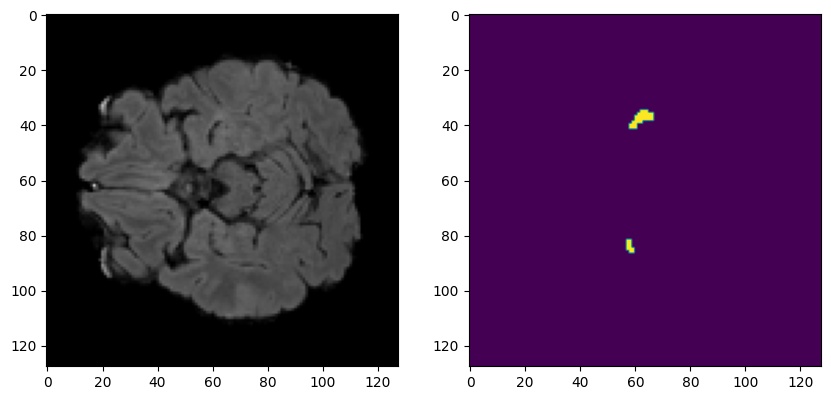

In [ ]:
show_input_sample(f_images)

In [ ]:
if save_input_classes:
    f_images0 = []
    f_images1 = []

    for f in f_images:
        with ZipFile(DATA_PATH + zip_name) as archive:
            data = archive.read(f)
            print(f[:-5] + '+mask.tiff')
            data1 = archive.read(f[:-5] + '+mask.tiff')

            mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
      #      print(mask.max(),mask.min(),np.unique(mask))
            if mask.max() < 127:
                f_images0.append(f)
            else:
                f_images1.append(f)

    with open(DATA_PATH + "fN_im0.txt", "w") as fl:
        for f in f_images0:
            fl.write(f + '\n')

    with open(DATA_PATH + "fN_im1.txt", "w") as fl:
        for f in f_images1:
            fl.write(f + '\n')

In [ ]:
with open(DATA_PATH + "fN_im0.txt", "r") as fl:
    f_images0 = fl.readlines()

f_images0 = [f.strip() for f in f_images0]

with open(DATA_PATH + "fN_im1.txt", "r") as fl:
    f_images1 = fl.readlines()

f_images1 = [f.strip() for f in f_images1]

In [ ]:
len(f_images0), len(f_images1)

(2236, 1565)

ISSBI2015/training4/training04_02_flair_pp_slice_105+mask.tiff
255 0 [  0 255]


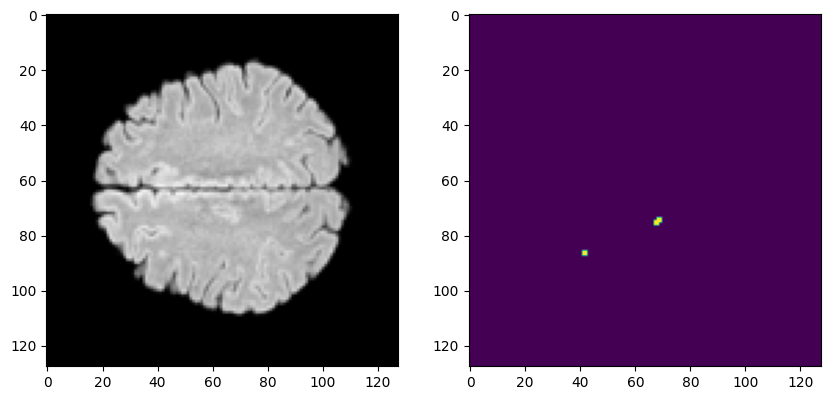

In [ ]:
show_input_sample(f_images1)

ISSBI2015/training2/training02_03_flair_pp_slice_22+mask.tiff
0 0 [0]


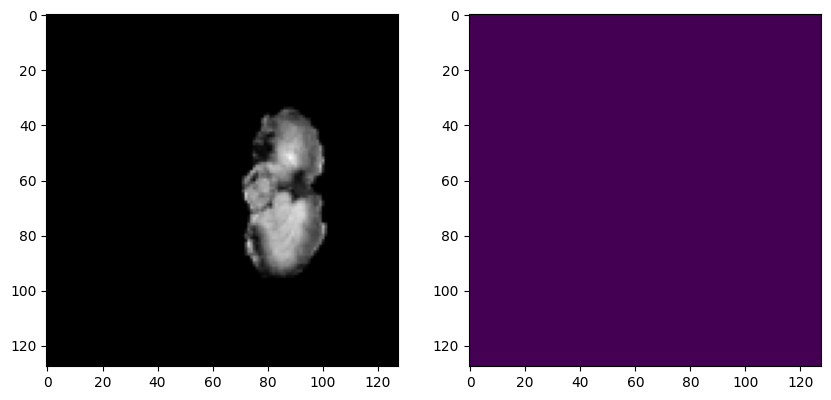

In [ ]:
show_input_sample(f_images0)

In [ ]:
if save_train_test_splitting:
    random.shuffle(f_images0)
    train_len0 = int(0.9 * len(f_images0))
    df_train0 = f_images0[:train_len0]
    df_test0 = f_images0[train_len0:]

    random.shuffle(f_images1)
    train_len1 = int(0.9 * len(f_images1))
    df_train1 = f_images1[:train_len1]
    df_test1 = f_images1[train_len1:]

    #To make a balanced training dataset:

    diff = len(df_train0) - len(df_train1)
    random.shuffle(df_train1)
    df_train1.extend(df_train1[:diff])

    df_train = df_train0
    df_test = df_test0

    df_train.extend(df_train1)
    df_test.extend(df_test1)

    with open(DATA_PATH + 'dfN_train.txt', 'w') as fl:
        for f in df_train0:
            fl.write(f + '\n')

    with open(DATA_PATH + 'dfN_test.txt', 'w') as fl:
        for f in df_test0:
            fl.write(f + '\n')

In [ ]:
with open(DATA_PATH + 'dfN_train.txt', 'r') as fl:
    df_train = fl.readlines()
df_train = [f.strip() for f in df_train]

with open(DATA_PATH + 'dfN_test.txt', 'r') as fl:
    df_test = fl.readlines()
df_test = [f.strip() for f in df_test]

print(len(df_train))
print(len(df_test))

4024
381


In [ ]:
# just to verify that the test data is not included in the training set
for dl in df_test:
    if dl in df_train:
        print('test line in the train set!!!')

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-large-patch4-window12-192-22k")
model_seg = Swinv2Model.from_pretrained("microsoft/swinv2-large-patch4-window12-192-22k").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/915M [00:00<?, ?B/s]

In [ ]:
class SegmentDataset(Dataset):
    def __init__(self,
                 gen_df,
                 transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((r_size, r_size), interpolation=transforms.InterpolationMode.NEAREST_EXACT)
                 ]),
                 mask_color='GRAY'):
        self.gen_df = gen_df
        self.transform = transform
        self.mask_color = mask_color

    def __getitem__(self, index):
        img_name = self.gen_df[index]

        with ZipFile(DATA_PATH + zip_name) as archive:
            data = archive.read(img_name)
            data1 = archive.read(img_name[:-5] + '+mask.tiff')

        img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
        if self.mask_color == 'GRAY':
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        img_in = self.transform(img)
        mask = self.transform(mask)

        img = Image.fromarray(img)
        img = image_processor(images=img, return_tensors="pt")

        x = model_seg.embeddings(**img.to(device))
        input_dimensions=x[1]
        img0 = x[0].detach().squeeze(0)

        x = model_seg.encoder.layers[0](x[0], input_dimensions=input_dimensions)
        img1 = x[0].detach().squeeze(0)

        x = model_seg.encoder.layers[1](x[0], input_dimensions=(input_dimensions[0]//2, input_dimensions[1]//2) )
        img2 = x[0].detach().squeeze(0)

        x = model_seg.encoder.layers[2](x[0], input_dimensions=(input_dimensions[0]//4, input_dimensions[1]//4) )
        img3 = x[0].detach().squeeze(0)

        x = model_seg.encoder.layers[3](x[0], input_dimensions=(input_dimensions[0]//8, input_dimensions[1]//8) )
        x = model_seg.layernorm(x[0])
        img4 = x.detach().squeeze(0)

        return img0, img1, img2, img3, img4, mask, img_in

    def __len__(self):
        return len(self.gen_df)

In [ ]:
try_dataset = SegmentDataset(df_train, mask_color='RGB')

try_dataloader = DataLoader(try_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(try_dataloader)

torch.Size([8, 2304, 192]) torch.Size([8, 576, 384]) torch.Size([8, 144, 768]) torch.Size([8, 36, 1536]) torch.Size([8, 36, 1536])
torch.Size([8, 3, 256, 256]) torch.Size([8, 3, 256, 256])


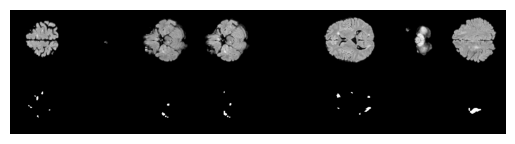

In [ ]:
i0, i1, i2, i3, i4, y, x1 = next(dataiter)
print(i0.shape, i1.shape, i2.shape, i3.shape, i4.shape)
print(y.shape, x1.shape)

concatenated = torch.cat((x1, y),0)
c_img = torchvision.utils.make_grid(concatenated).permute(1, 2, 0)
plt.axis("off")
plt.imshow(c_img)

In [ ]:
del try_dataloader
del try_dataset
del concatenated
del c_img

In [ ]:
train_dataset = SegmentDataset(df_train, mask_color='GRAY')

In [ ]:
class Up_Linear(nn.Module):
    def __init__(self, in_ch, size, coef=1):
        super(Up_Linear, self).__init__()
        self.shuffle = nn.PixelShuffle(upscale_factor=2)

        n_ch = int(coef * in_ch)

        self.ln = nn.Sequential(
            nn.Linear(in_ch * 2, n_ch),
            nn.ReLU(inplace=True),
            nn.Linear(n_ch, in_ch * 2),
            nn.ReLU(inplace=True),
        )

        self.size = size

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), 2)
        x = self.ln(x)
        x = x.permute(0, 2, 1)
        x = torch.reshape(x, (x.shape[0], x.shape[1], self.size, self.size))
        x = self.shuffle(x)
        x = torch.reshape(x, (x.shape[0], x.shape[1], self.size*self.size*4))
        x = x.permute(0, 2, 1)
        return x

class MRI_Seg(nn.Module):
    def __init__(self):
        super(MRI_Seg, self).__init__()

        self.ups3 = Up_Linear(1536, 6, 1)
        self.ups2 = Up_Linear(768, 12, 1)
        self.ups1 = Up_Linear(384, 24, 2)
        self.ups0 = Up_Linear(192, 48, 3)

        self.shuffle = nn.PixelShuffle(upscale_factor=2)

        self.out = nn.Sequential(
            nn.Conv2d(24, 1, kernel_size=1, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x0, x1, x2, x3, x4):
        x = self.ups3(x4, x3)
        x = self.ups2(x, x2)
        x = self.ups1(x, x1)
        x = self.ups0(x, x0)

        x = x.permute(0, 2, 1)
        x = torch.reshape(x, (x.shape[0], x.shape[1], 96, 96))
        x = self.shuffle(x)
        x = transforms.Resize((256, 256))(x)

        x = self.out(x)
        return x


In [ ]:
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=batch_size)

net = MRI_Seg().to(device)

criterion = nn.BCELoss()
lr = 0.0001
optimizer = optim.Adam(net.parameters(), lr=lr)

In [ ]:
len(train_dataloader)

252

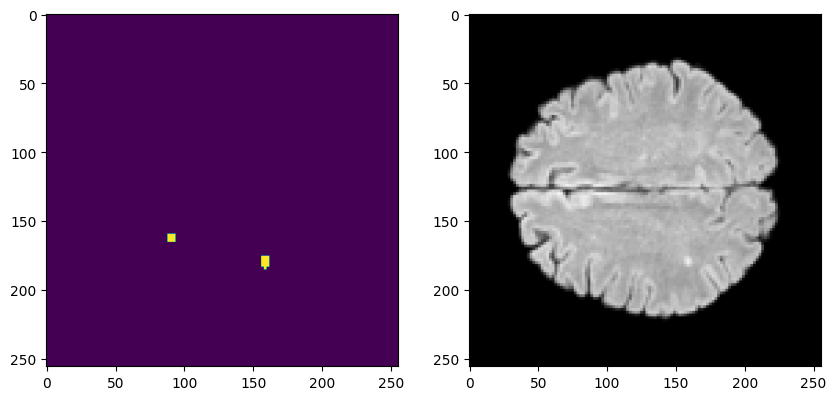

In [ ]:
dataiter = iter(train_dataloader)
i0, i1, i2, i3, i4, y, x1 = next(dataiter)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].imshow(y[0].permute(1, 2, 0))
axes[1].imshow(x1[0].permute(1, 2, 0))
plt.show()

In [ ]:
summary(model=net, input_size=[(1, 2304, 192), (1, 576, 384), (1, 144, 768), (1, 36, 1536), (1, 36, 1536)], col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
MRI_Seg                                  [1, 2304, 192]            [1, 1, 256, 256]          --                        True
├─Up_Linear: 1-1                         [1, 36, 1536]             [1, 144, 768]             --                        True
│    └─Sequential: 2-1                   [1, 36, 3072]             [1, 36, 3072]             --                        True
│    │    └─Linear: 3-1                  [1, 36, 3072]             [1, 36, 1536]             4,720,128                 True
│    │    └─ReLU: 3-2                    [1, 36, 1536]             [1, 36, 1536]             --                        --
│    │    └─Linear: 3-3                  [1, 36, 1536]             [1, 36, 3072]             4,721,664                 True
│    │    └─ReLU: 3-4                    [1, 36, 3072]             [1, 36, 3072]             --                        --
│    └─

In [ ]:
net.eval().to(device)

MRI_Seg(
  (ups3): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=3072, out_features=1536, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1536, out_features=3072, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups2): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=1536, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=1536, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups1): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=768, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups0): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=384, 

torch.Size([16, 1, 256, 256]) torch.Size([1, 256, 256])
tensor(1.)
tensor(0.6978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


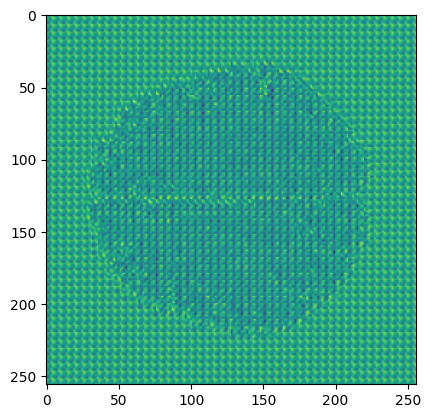

In [ ]:
out = net(Variable(i0).to(device), Variable(i1).to(device), Variable(i2).to(device), Variable(i3).to(device), Variable(i4).to(device))
print(out.shape, y[0].shape)
print(y[0].max())

ls = criterion(out[0], Variable(y[0]).to(device))

print(ls)
plt.imshow(out[0].cpu().detach().numpy()[0])
del out

In [ ]:
def train_net():
    num_iter = len(train_dataloader)
    ep_init = 0

    for epoch in range(ep_init, ep_num):
        sum_loss = 0
        print("Epoch number: {}".format(epoch))
        for i, data in enumerate(train_dataloader, 0):

            img0, img1, img2, img3, img4, mask, img_in = data

            optimizer.zero_grad()

            x0 = Variable(img0).to(device)
            x1 = Variable(img1).to(device)
            x2 = Variable(img2).to(device)
            x3 = Variable(img3).to(device)
            x4 = Variable(img4).to(device)

            output = net(x0, x1, x2, x3, x4)
            # label.squeeze() - to transform lables to 1-dim vector
            # without squeeze() loss calculation is incorrect
            loss_bce = criterion(output, Variable(mask).to(device))
            loss_bce.backward()
            optimizer.step()

            sum_loss += loss_bce.data
            if i % 10 == 0:
                print('{} ===================  {}'.format(i, sum_loss/(i + 1)))

        print("Epoch number: {}, Num iter: {}, lr: {}, Current loss: {}".format(epoch, num_iter, optimizer.param_groups[0]['lr'], sum_loss/num_iter))
        torch.save(net, FILE_NAME + '_{}'.format(epoch + 1))

    torch.save(net, FILE_NAME)
    print("The pre-trained model saved")

In [ ]:
if use_pre_trained is False:
    net.train().to(device)
    train_net()

Epoch number: 0
0 ===================  0.7509981393814087
10 ===================  0.6980969309806824
20 ===================  0.6170716881752014
30 ===================  0.45471110939979553
40 ===================  0.3680468201637268
50 ===================  0.30406635999679565
60 ===================  0.25801631808280945
70 ===================  0.22430302202701569
80 ===================  0.19914570450782776
90 ===================  0.1789054423570633
100 ===================  0.162687286734581
110 ===================  0.14976592361927032
120 ===================  0.13859160244464874
130 ===================  0.12933316826820374
140 ===================  0.12102537602186203
150 ===================  0.11382931470870972
160 ===================  0.10780613124370575
170 ===================  0.10226431488990784
180 ===================  0.097414031624794
190 ===================  0.0931495949625969
200 ===================  0.08922421932220459
210 ===================  0.08568666130304337
220 ===========

In [ ]:
def calc_rect(img_mask):
    ind = np.argwhere(img_mask >= 0.5)
    if len(ind) == 0:
        return None, None
    top_y = min(ind[:,0])
    bottom_y = max(ind[:,0])
    top_x = min(ind[:,1])
    bottom_x = max(ind[:,1])
    return (top_x, top_y), (bottom_x, bottom_y)

def show_results(i0, i1, i2, i3, i4, y, x1, im_id):
    ii0 = Variable(i0).to(device)
    ii1 = Variable(i1).to(device)
    ii2 = Variable(i2).to(device)
    ii3 = Variable(i3).to(device)
    ii4 = Variable(i4).to(device)
    pred = net(ii0, ii1, ii2, ii3, ii4)
    pr = pred[im_id].cpu().detach().numpy()[0]

    xim = copy.deepcopy(x1[im_id].permute(1, 2, 0).cpu().detach().numpy())
    # just to transform numpy array to cv2 image:
    xim = cv2.resize(xim, (r_size, r_size))
    top_left, bottom_right = calc_rect(pr)
    if top_left is not None:
        cv2.rectangle(xim, top_left, bottom_right, (255, 0, 0), 2)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(y[im_id].cpu().detach().numpy()[0])
    axes[1].imshow(pr > 0.5)
    axes[2].imshow(xim)

    plt.show()

In [ ]:
if use_pre_trained:
    del net
    net = torch.load(FILE_NAME_PR)
    print("The pre-trained model loaded")

<ipython-input-46-b07dbf5224e1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(FILE_NAME_PR)


The pre-trained model loaded


In [ ]:
net.eval().to(device)

MRI_Seg(
  (ups3): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=3072, out_features=1536, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1536, out_features=3072, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups2): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=1536, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=1536, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups1): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=768, out_features=768, bias=True)
      (3): ReLU(inplace=True)
    )
  )
  (ups0): Up_Linear(
    (shuffle): PixelShuffle(upscale_factor=2)
    (ln): Sequential(
      (0): Linear(in_features=384, 

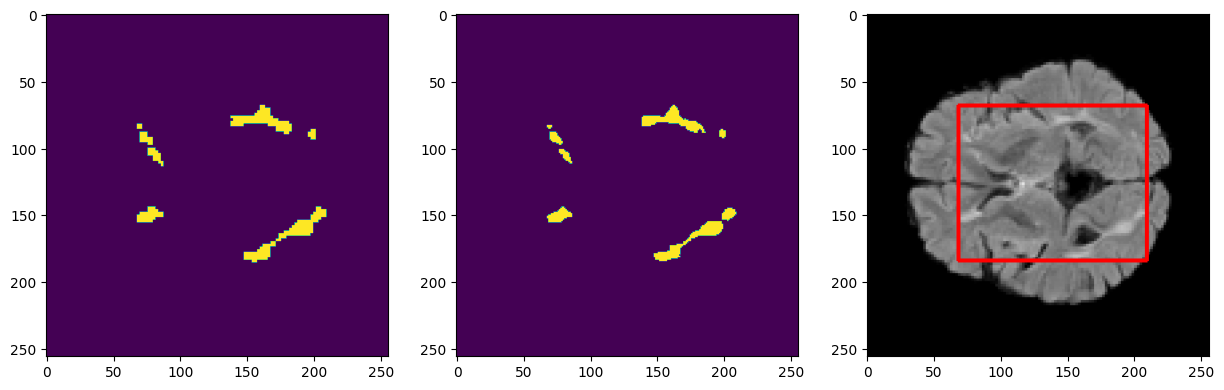

In [ ]:
show_results(i0, i1, i2, i3, i4, y, x1, 2)

In [ ]:
test_dataloader1 = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1)

test_dataset = SegmentDataset(df_test)
test_dataloader2 = DataLoader(test_dataset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)

In [ ]:
dataiter = iter(test_dataloader1)

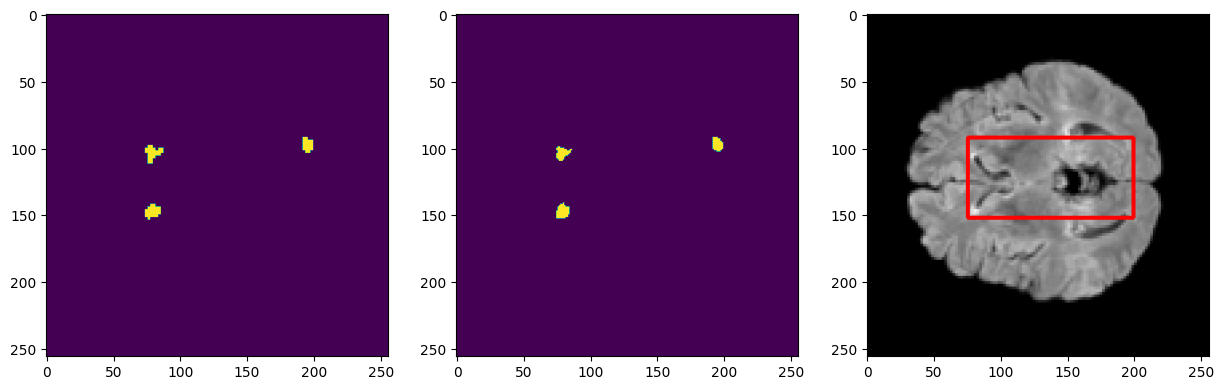

In [ ]:
i0, i1, i2, i3, i4, y, x1 = next(dataiter)
show_results(i0, i1, i2, i3, i4, y, x1, 0)

In [ ]:
def calc_accuracy(test_dataloader, set_id, model, sample_num=None):
    batch_size = 1
    if not sample_num:
        N = len(test_dataloader)
    else:
        if sample_num <= 0:
            sample_num = len(test_dataloader)
        N = min(sample_num, len(test_dataloader))

    And = 0
    Uni = 0
    Uni_dice = 0

    T0 = 0
    T1 = 0
    F0 = 0
    F1 = 0

    for i, data in enumerate(test_dataloader, 0):
        #xx, yy, xs = data
        img0, img1, img2, img3, img4, yy, xs = data

        x0 = Variable(img0).to(device)
        x1 = Variable(img1).to(device)
        x2 = Variable(img2).to(device)
        x3 = Variable(img3).to(device)
        x4 = Variable(img4).to(device)

        xx1 = model(x0, x1, x2, x3, x4)
        xx1 = xx1[0][0].cpu().detach().numpy()
        yy = yy[0][0].cpu().detach().numpy()
        xx1[xx1 >= 0.5 ] = 1
        xx1[xx1 < 0.5 ] = 0

        owl = np.sum(xx1*yy)
        And += owl
        a_uni_dice = np.sum(xx1 + yy)
        a_uni = a_uni_dice - owl
        Uni += a_uni
        Uni_dice += a_uni_dice

        if xx1.max() == 0 and yy.max() == 0:
            T0 += 1
        if xx1.max() == 1 and yy.max() == 1:
            T1 += 1
        if xx1.max() == 0 and yy.max() == 1:
            F0 += 1
        if xx1.max() == 1 and yy.max() == 0:
            F1 += 1

        print('{}:  i = {}, And = {}, Uni = {}'.format(set_id, i, And, Uni))

        if i >= N - 1:
            break

    IoU_av = And / Uni
    Dice = 2*And / Uni_dice

    return  IoU_av, Dice, T0, T1, F0, F1


In [ ]:
IoU_tr, Dice_tr, T0_tr, T1_tr, F0_tr, F1_tr = calc_accuracy(test_dataloader1, 'train', net, sample_num=550)

train:  i = 0, And = 220.0, Uni = 263.0
train:  i = 1, And = 297.0, Uni = 375.0
train:  i = 2, And = 297.0, Uni = 375.0
train:  i = 3, And = 324.0, Uni = 410.0
train:  i = 4, And = 381.0, Uni = 482.0
train:  i = 5, And = 717.0, Uni = 899.0
train:  i = 6, And = 2714.0, Uni = 3172.0
train:  i = 7, And = 3066.0, Uni = 3665.0
train:  i = 8, And = 3066.0, Uni = 3665.0
train:  i = 9, And = 3818.0, Uni = 4597.0
train:  i = 10, And = 3818.0, Uni = 4597.0
train:  i = 11, And = 3818.0, Uni = 4597.0
train:  i = 12, And = 3818.0, Uni = 4597.0
train:  i = 13, And = 4099.0, Uni = 5010.0
train:  i = 14, And = 4236.0, Uni = 5202.0
train:  i = 15, And = 4236.0, Uni = 5202.0
train:  i = 16, And = 5042.0, Uni = 6221.0
train:  i = 17, And = 5179.0, Uni = 6416.0
train:  i = 18, And = 5226.0, Uni = 6482.0
train:  i = 19, And = 5226.0, Uni = 6482.0
train:  i = 20, And = 5226.0, Uni = 6482.0
train:  i = 21, And = 6331.0, Uni = 7832.0
train:  i = 22, And = 6474.0, Uni = 8023.0
train:  i = 23, And = 6474.0, Uni

In [ ]:
print('training set: IoU = {}, Dice = {}, True_0 = {}, True_1 = {}, False_0 = {}, False_1 = {}'.format(IoU_tr, Dice_tr, T0_tr, T1_tr, F0_tr, F1_tr))

training set: IoU = 0.7971569839307787, Dice = 0.8871311644542266, True_0 = 284, True_1 = 265, False_0 = 1, False_1 = 0


In [ ]:
IoU_ts, Dice_ts, T0_ts, T1_ts, F0_ts, F1_ts = calc_accuracy(test_dataloader2, 'test', net)

test:  i = 0, And = 0.0, Uni = 0.0
test:  i = 1, And = 0.0, Uni = 0.0
test:  i = 2, And = 0.0, Uni = 0.0
test:  i = 3, And = 0.0, Uni = 0.0
test:  i = 4, And = 0.0, Uni = 0.0
test:  i = 5, And = 0.0, Uni = 0.0
test:  i = 6, And = 0.0, Uni = 0.0
test:  i = 7, And = 0.0, Uni = 0.0
test:  i = 8, And = 0.0, Uni = 0.0
test:  i = 9, And = 0.0, Uni = 0.0
test:  i = 10, And = 0.0, Uni = 0.0
test:  i = 11, And = 0.0, Uni = 0.0
test:  i = 12, And = 0.0, Uni = 0.0
test:  i = 13, And = 0.0, Uni = 0.0
test:  i = 14, And = 0.0, Uni = 0.0
test:  i = 15, And = 0.0, Uni = 0.0
test:  i = 16, And = 0.0, Uni = 0.0
test:  i = 17, And = 0.0, Uni = 0.0
test:  i = 18, And = 0.0, Uni = 0.0
test:  i = 19, And = 0.0, Uni = 0.0
test:  i = 20, And = 0.0, Uni = 0.0
test:  i = 21, And = 0.0, Uni = 0.0
test:  i = 22, And = 0.0, Uni = 0.0
test:  i = 23, And = 0.0, Uni = 0.0
test:  i = 24, And = 0.0, Uni = 0.0
test:  i = 25, And = 0.0, Uni = 0.0
test:  i = 26, And = 0.0, Uni = 0.0
test:  i = 27, And = 0.0, Uni = 0.0
te

In [ ]:
print('test set: IoU = {}, Dice = {}, True_0 = {}, True_1 = {}, False_0 = {}, False_1 = {}'.format(IoU_ts, Dice_ts, T0_ts, T1_ts, F0_ts, F1_ts))

test set: IoU = 0.7110136811337902, Dice = 0.8311022746032544, True_0 = 221, True_1 = 155, False_0 = 2, False_1 = 3
